In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math

In [ ]:
df = pd.read_csv('all_times.csv')
t = df['T_mid'].to_numpy()
epoch = df['Orbit number'].to_numpy()
uncertainty = df['Uncertainty (days)'].to_numpy()

In [68]:
start_nickel = np.where(epoch==634)[0][0]

t0_true = 2459204.57267399 # t0 for transit with epoch=302-302=0
Ps_true = 1.4079405
e_true = 0.0
omega0_true = 0.0
domega_dE_true = 0.0
f_true = 0.01

In [69]:
epoch -= 302 # try to eliminate correlation between P and dP/dN

In [ ]:
def log_likelihood(theta, x, y, yerr):
    t0, Ps, e, omega0, domega_dE, log_f = theta
    if e < 0 or e > 1: # necessary to avoid unphysical eccentricity in maximum likelihood estimate
        return -np.inf
    Pa = Ps / (1 - domega_dE / (2*np.pi))
    omega = omega0 + x * domega_dE
    model = t0 + Ps * x - e * Pa * np.cos(omega) / np.pi
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

nll = lambda *args: -log_likelihood(*args)
initial = np.array([t0_true, Ps_true, e_true, omega0_true, domega_dE_true, np.log(f_true)])
soln = minimize(nll, initial, args=(epoch, t, uncertainty))
t0_ml, Ps_ml, e_ml, omega0_ml, domega_dE_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("t0= {0:.3f}".format(t0_ml))
print("Ps = {0:.3f}".format(Ps_ml))
print("e = {0:.3f}".format(e_ml))
print("omega0 = {0:.3f}".format(omega0_ml))
print("domega/dE = {0:.3f}".format(domega_dE_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
t0= 2459204.573
Ps = 1.407
e = 0.000
omega0 = 0.000
domega/dE = 0.000
f = 0.000


/Users/eligendreaudistler/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [71]:
def log_prior(theta):
    t0, Ps, e, omega0, domega_dE, log_f = theta
    if t0_true-1e-3 < t0 < t0_true+1e-3 and Ps_true-1e-2 < Ps < Ps_true+1e-2 and 0 <= e < 0.1 and -np.pi < omega0 < np.pi and -0.5 < domega_dE < 0.5 and -40 < log_f < 0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [72]:
soln.x = [t0_ml, Ps_ml, 0.0, 0.0, 0.0, -1]

In [ ]:
pos = soln.x + 1e-4 * np.random.randn(128, 6)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(epoch, t, uncertainty), a=1.5 # reducing a could help increase acceptance fraction (doesn't seem to have worked)
)
sampler.run_mcmc(pos, 100_000, progress=True);

  0%|          | 0/100000 [00:00<?, ?it/s]/Users/eligendreaudistler/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100000/100000 [05:03<00:00, 329.60it/s]


In [74]:
# check mean acceptance fraction and autocorrelation time
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
try:
    print("Autocorr time (per param):", sampler.get_autocorr_time())
except Exception as e:
    print("Autocorr time not estimated yet:", e)

Mean acceptance fraction: 0.10103070312500001
Autocorr time (per param): [  87.24371451   72.12059649  474.70410029 1047.67480026  962.03503377
 1023.38316365]


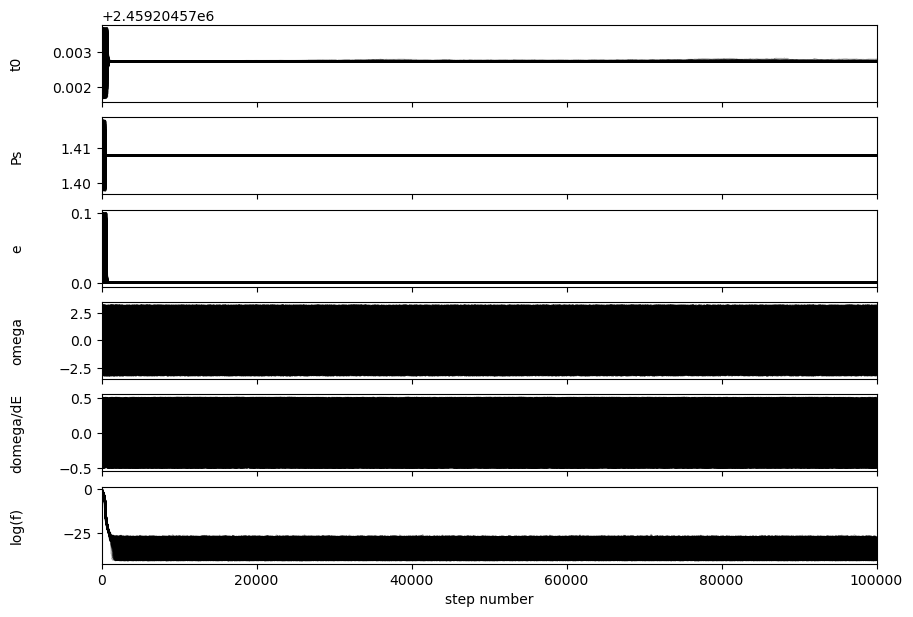

In [75]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t0", "Ps", "e", "omega", "domega/dE", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [76]:
labels = [r"$t_0$", f"$P_s$", r"$e$", r"$\omega_0$", r"$\frac{d\omega}{dE}$", r"$\log(f)$"]

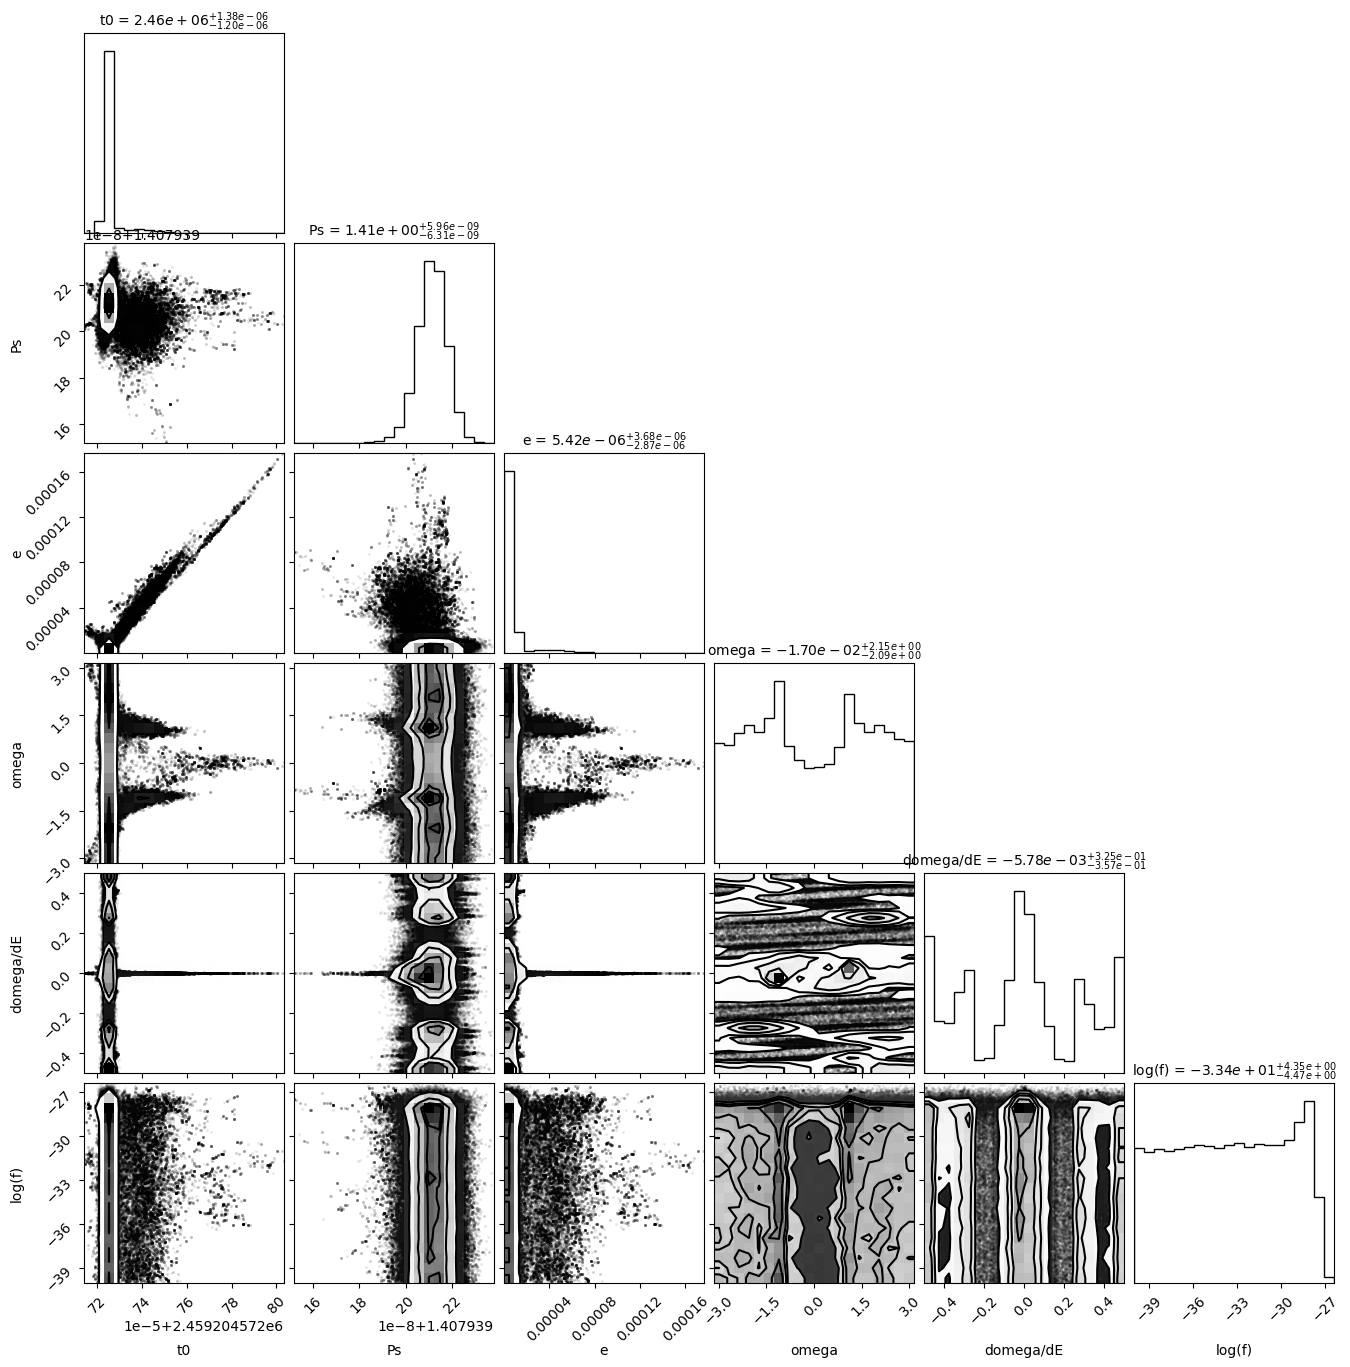

In [85]:
flat_samples = sampler.get_chain(discard=50000, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, show_titles=True, title_fmt=".2e", title_kwargs=dict(fontsize=10)
);

In [78]:
labels = ["t0", "Ps", "e", "omega", "domega/dE", "log(f)"]


In [79]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.10f}_{{-{1:.10f}}}^{{{2:.10f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [80]:
best_t0 = np.median(flat_samples[:, 0])
best_Ps = np.median(flat_samples[:, 1])
best_e = np.median(flat_samples[:, 2])
best_omega0 = np.median(flat_samples[:, 3])
best_domega_dE = np.median(flat_samples[:, 4])

Pa = best_Ps / (1 - best_domega_dE / (2*np.pi))
omega = best_omega0 + epoch * best_domega_dE
trend = best_t0 + best_Ps * epoch - best_e * Pa * np.cos(omega) / np.pi

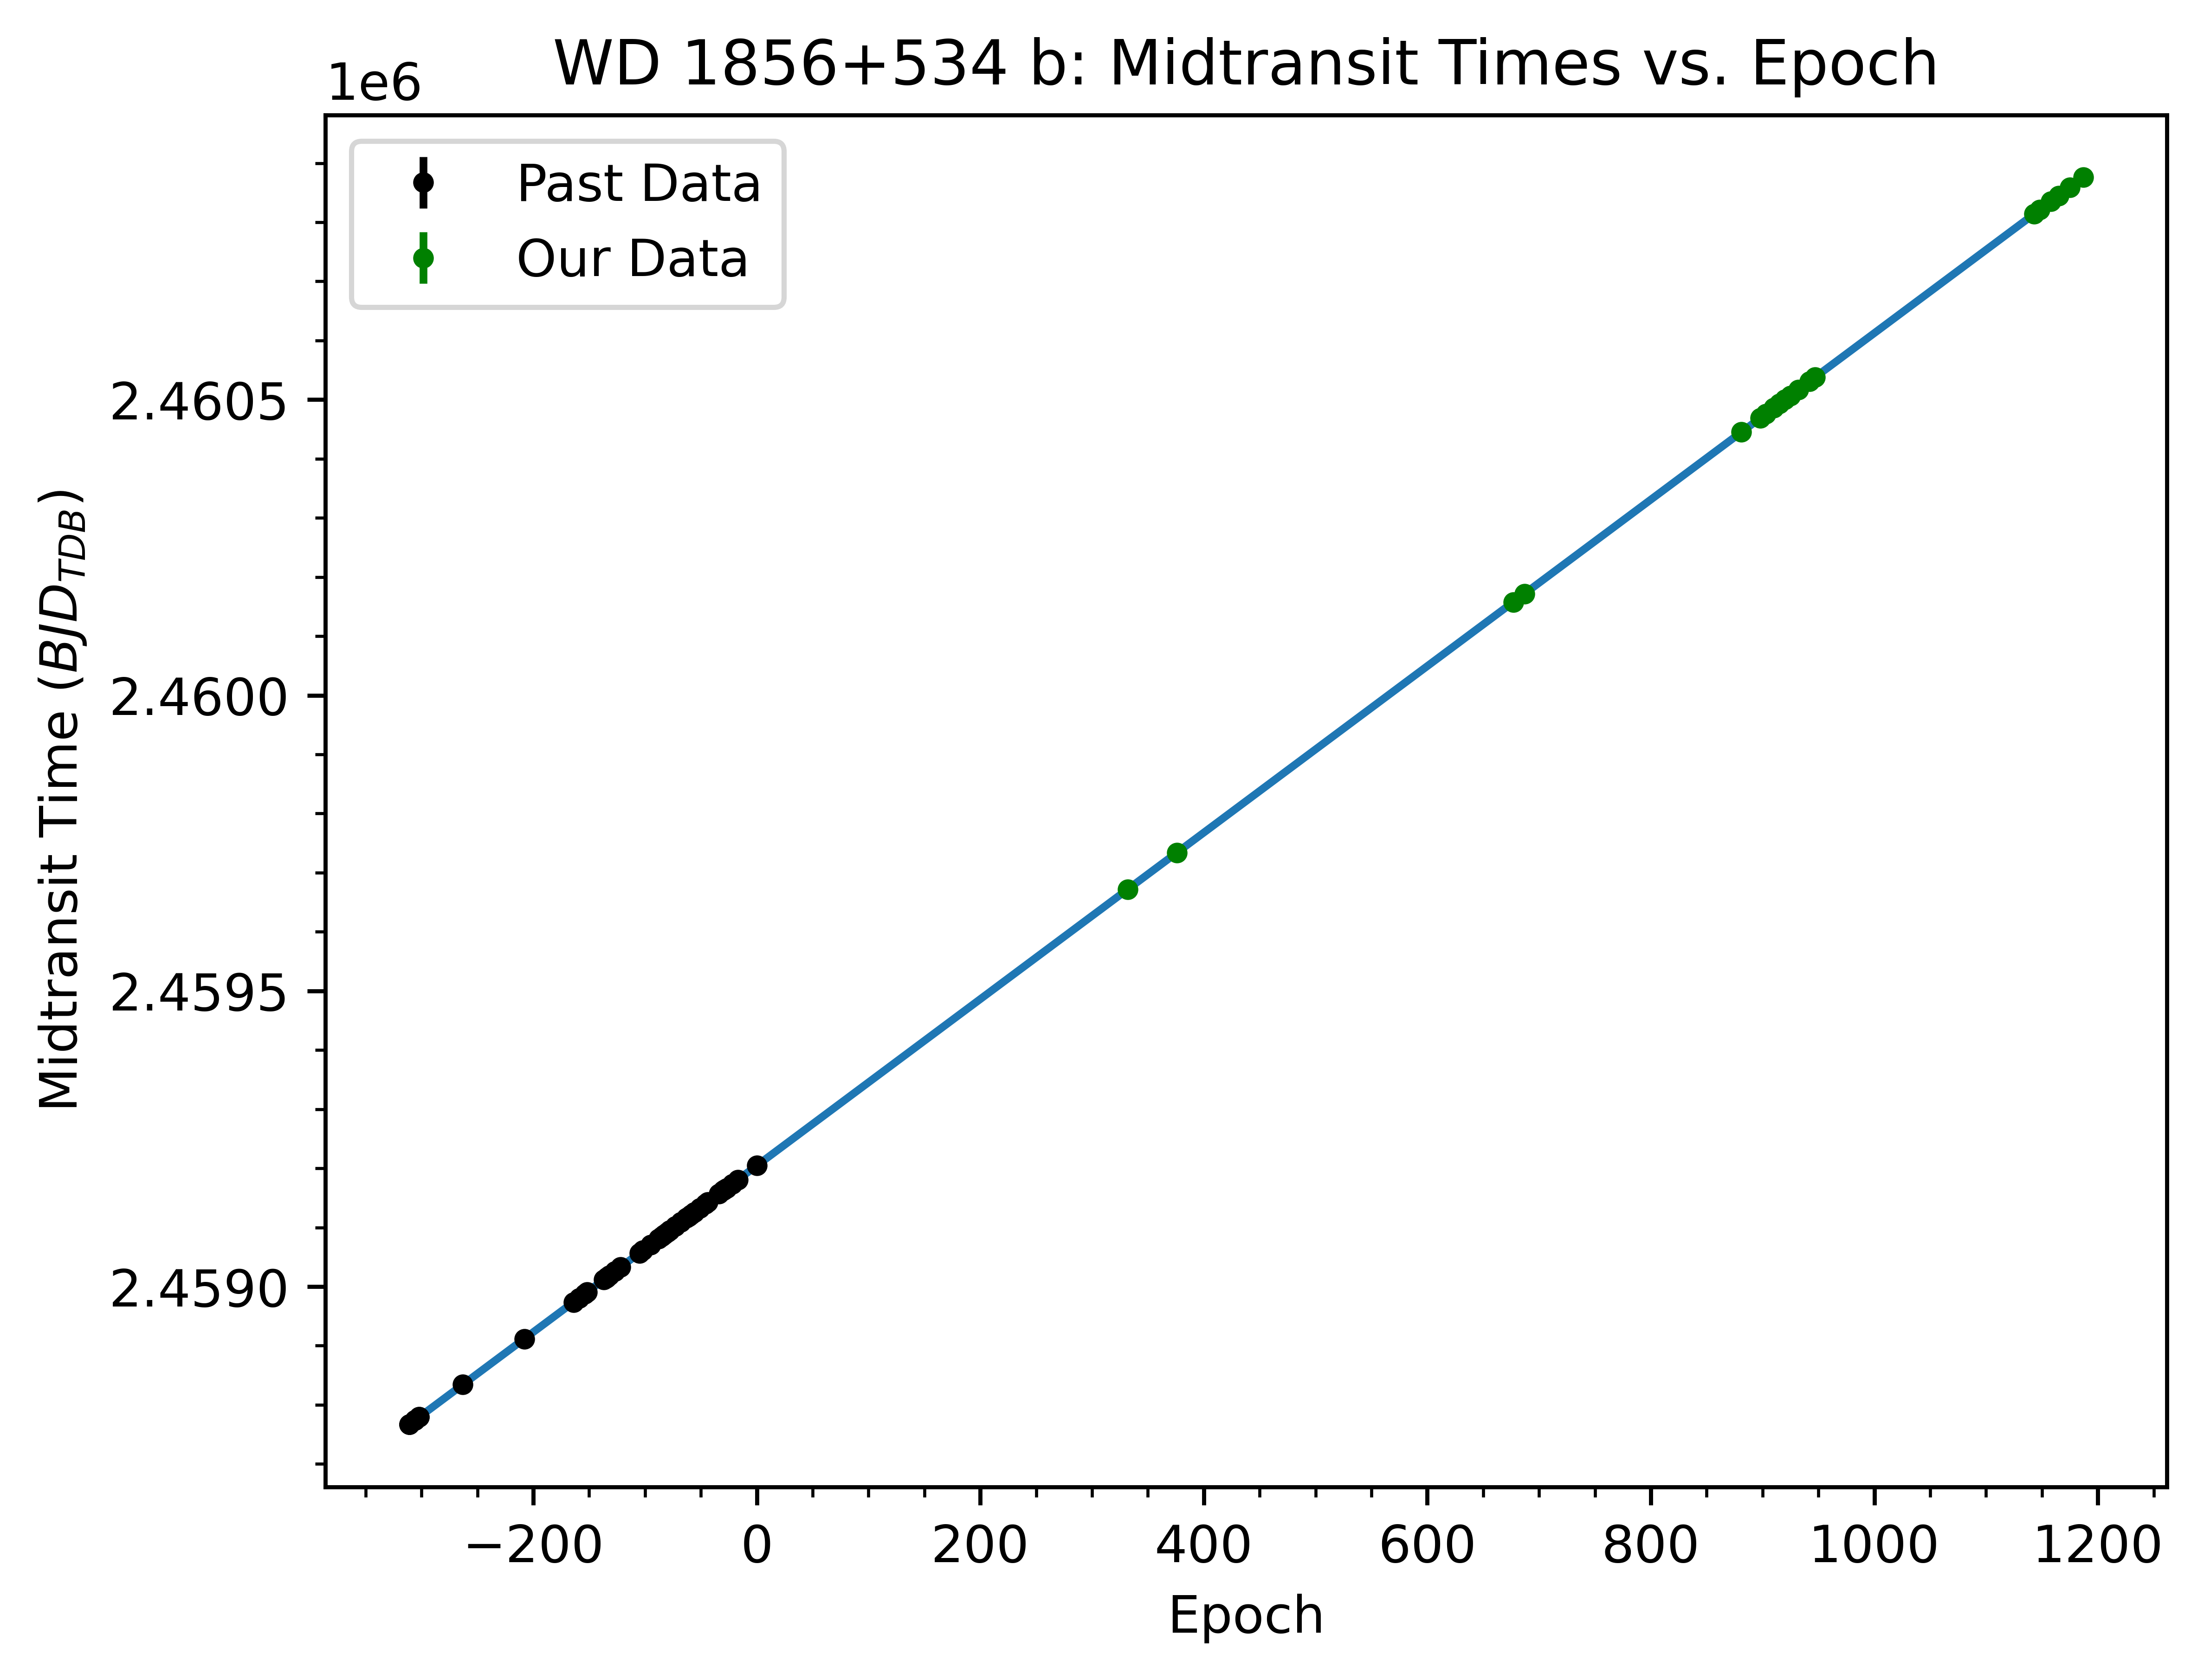

In [81]:
fig, ax = plt.subplots(dpi = 800)
plt.errorbar(epoch[:start_nickel],t[:start_nickel],yerr=uncertainty[:start_nickel],fmt='k.',label='Past Data')
plt.errorbar(epoch[start_nickel:],t[start_nickel:],yerr=uncertainty[start_nickel:],fmt='g.',label='Our Data')
plt.plot(epoch,trend)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Midtransit Time $(BJD_{TDB})$')
plt.title('WD 1856+534 b: Midtransit Times vs. Epoch')
ax.minorticks_on()

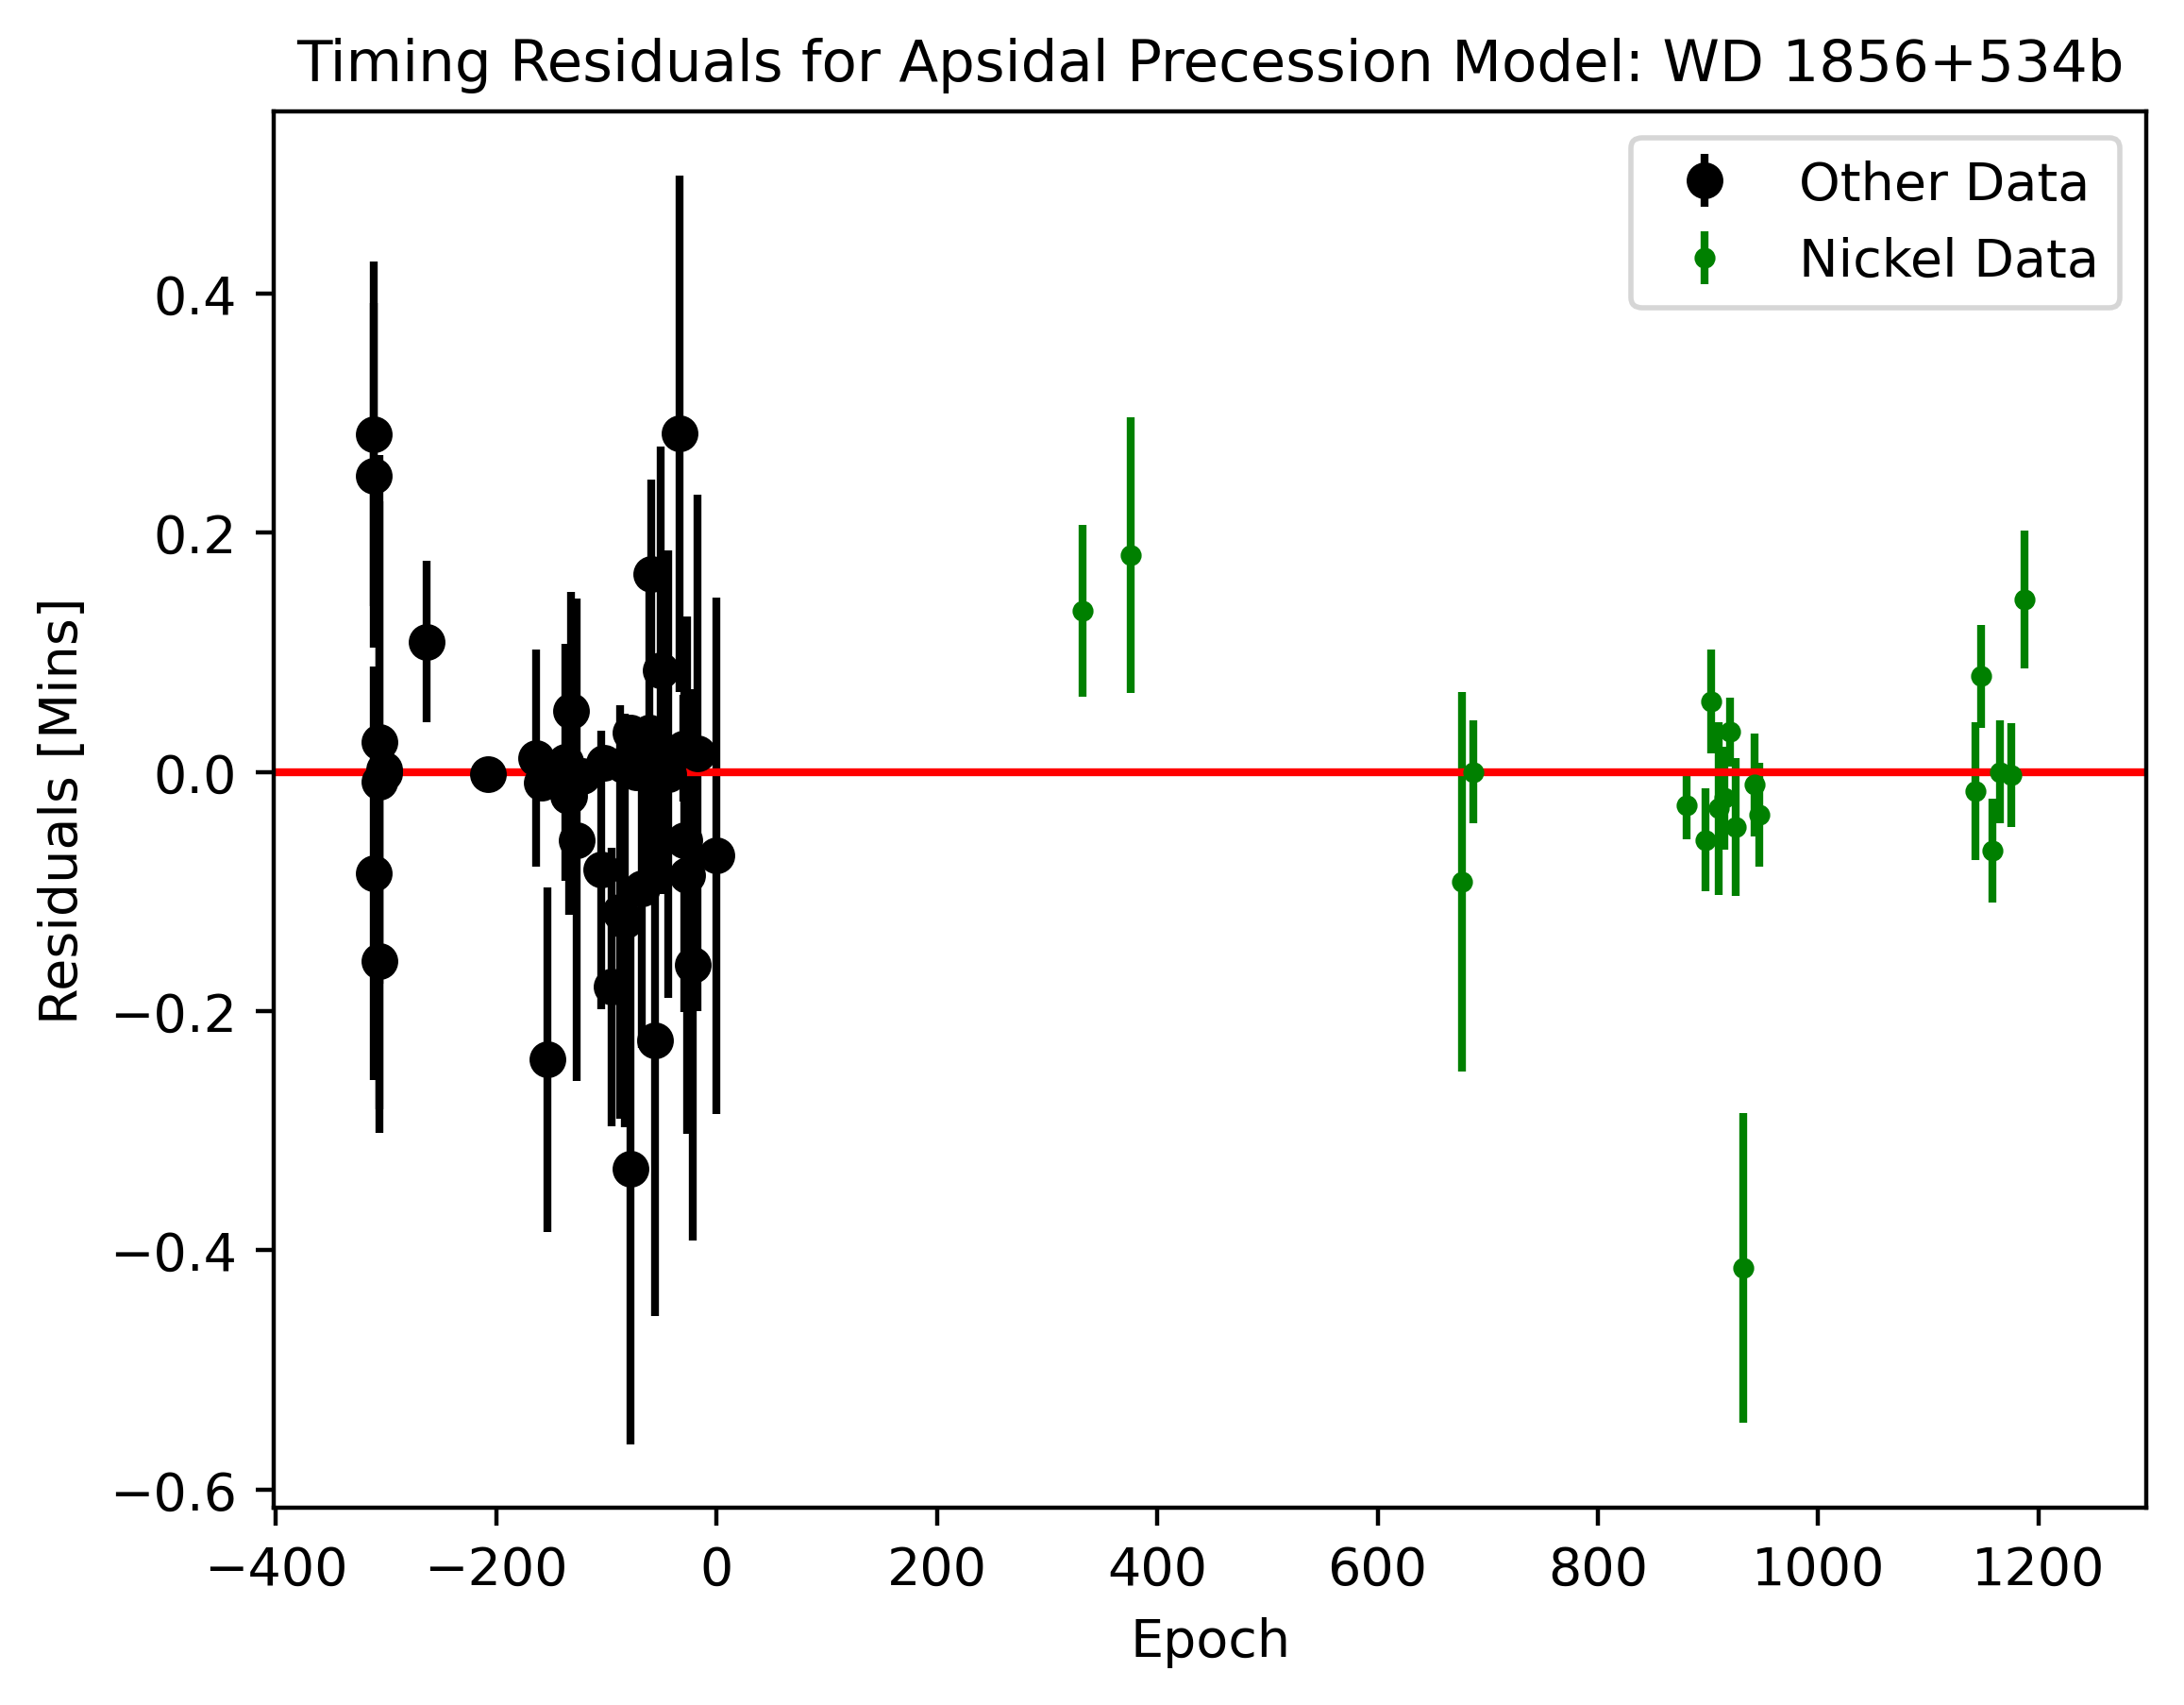

In [82]:
res = (t - trend) * 1440 # 1440 converts days to mins

plt.figure(dpi=400)
plt.errorbar(epoch[0:start_nickel],res[0:start_nickel],yerr=uncertainty[0:start_nickel]*1440,fmt='ok',capsize=0,label='Other Data')
plt.errorbar(epoch[start_nickel:],res[start_nickel:],yerr=uncertainty[start_nickel:]*1440,fmt='g.',capsize=0,label='Nickel Data')
plt.legend()
plt.xlim(-100-302,1600-302)
plt.hlines(y=0,xmin=-2500,xmax=2500,color='red')
plt.ylabel('Residuals [Mins]')
plt.xlabel('Epoch')
plt.title('Timing Residuals for Apsidal Precession Model: WD 1856+534b', fontsize=11)
ax.minorticks_on()
plt.legend(loc='best')

In [83]:
def chi_squared_reduced(data, model, sigma, dof=None):
    """
    Calculate the reduced chi-squared value for a fit.

    If no dof is given, returns the chi-squared (non-reduced) value.

    Parameters
    ----------
    data : array_like
        The observed data.
    model : array_like
        The model data.
    sigma : array_like
        The uncertainty in the data.
    dof : int
        Degrees of freedom (len(data) - # of free parameters).
    """

    sq_residual = (data - model)**2
    chi_sq = np.sum(sq_residual / sigma**2)
    if dof is None:
        return chi_sq
    else:
        nu = len(data) - dof
        return chi_sq / nu

# Define our data, model, uncertainty, and degrees of freedom
I_data = t  # observed data
I_modeled = trend # model fitted result
I_sigma = uncertainty # uncertainty in the data

# Calculate the Chi-Squared value (no dof)
chisq = chi_squared_reduced(I_data, I_modeled, I_sigma)
print(f"chi-squared statistic = {chisq:1.2f}")

# Calculate the Reduced Chi-Squared value (with dof)
dof = 5 # We have five free parameters
rechisq = chi_squared_reduced(I_data, I_modeled, I_sigma, dof)
print(f"reduced chi-squared = {rechisq:1.2f}")

chi-squared statistic = 100.60
reduced chi-squared = 1.60


In [84]:
BIC = chisq + 2*np.log(len(I_data))
print(f"BIC = {BIC:1.2f}")

BIC = 109.04
